In [85]:
import tensorflow as tf
import numpy as np
import os
import random
import time
import matplotlib
matplotlib.rcParams['toolbar'] = 'None' 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

class AllCNN(tf.keras.Model):
    # structure of the model
    def __init__(self, input_shape=(None, 32, 32, 3), name='All-CNN-C'):
        super(AllCNN, self).__init__(name=name)
        self.conv1_1 = Conv2D(96, (3, 3), input_shape=input_shape, padding='same', activation='relu')
        self.conv1_2 = Conv2D(96, (3, 3), padding='same', activation='relu')
        self.conv2_1 = Conv2D(96, (3, 3), padding='same', activation='relu', strides=2)
        self.conv3_1 = Conv2D(192, (3, 3), padding='same', activation='relu')
        self.conv3_2 = Conv2D(192, (3, 3), padding='same', activation='relu')
        self.conv4_1 = Conv2D(192, (3, 3), padding='same', activation='relu', strides=2)
        self.conv5_1 = Conv2D(192, (3, 3), padding='valid', activation='relu')
        self.conv5_2 = Conv2D(192, (1, 1), padding='same', activation='relu')
        self.conv5_3 = Conv2D(10, (1, 1), padding='same', activation='relu')
        self.gav = GlobalAveragePooling2D()

    def call(self, inputs):
        x = self.conv1_1(inputs)
        x = self.conv1_2(x)
        x = self.conv2_1(x)
        x = tf.nn.dropout(x, 0.5)
        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv4_1(x)
        x = tf.nn.dropout(x, 0.5)
        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)
        x = self.gav(x)
        x = tf.nn.softmax(x)
        return x
    
    def model(self, shape=(None, 32, 32, 3)):
        x = tf.keras.Input(shape=shape[1:])
        return tf.keras.Model(inputs=[x], outputs=self.call(x), name=self.name)

    def summary(self, shape=(None, 32, 32, 3)):
        return self.model(shape).summary()

# model path
model_path = 'AllCNN.h5'

# data
cifar10 = tf.keras.datasets.cifar10
((x_train, y_train), (x_test, y_test)) = cifar10.load_data()
# normalized  the data
x_train_n, x_test_n = x_train / 255.0, x_test / 255.0

# label names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# training hyperparameters
batch_size = 32
learning_rate = 0.01
optimizer = 'SGD'
epochs = 20

# structure of the model
model = AllCNN(input_shape=(None, 32, 32, 3))

In [86]:
model.summary()

Model: "All-CNN-C"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_468 (Conv2D)             (None, 32, 32, 96)   2688        input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_469 (Conv2D)             (None, 32, 32, 96)   83040       conv2d_468[0][0]                 
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 16, 16, 96)   83040       conv2d_469[0][0]                 
__________________________________________________________________________________________

Epoch 1/20
1563/1563 [==============================] - 23s 14ms/step - loss: 2.1853 - accuracy: 0.1866 - val_loss: 2.0332 - val_accuracy: 0.2949
Epoch 2/20
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8439 - accuracy: 0.3201 - val_loss: 1.6408 - val_accuracy: 0.3991
Epoch 3/20
1563/1563 [==============================] - 23s 14ms/step - loss: 1.5635 - accuracy: 0.4204 - val_loss: 1.4079 - val_accuracy: 0.4801
Epoch 4/20
1563/1563 [==============================] - 23s 15ms/step - loss: 1.3931 - accuracy: 0.4873 - val_loss: 1.2850 - val_accuracy: 0.5244
Epoch 5/20
1563/1563 [==============================] - 23s 15ms/step - loss: 1.2554 - accuracy: 0.5413 - val_loss: 1.1792 - val_accuracy: 0.5720
Epoch 6/20
1563/1563 [==============================] - 23s 15ms/step - loss: 1.1167 - accuracy: 0.5982 - val_loss: 1.0799 - val_accuracy: 0.6068
Epoch 7/20
1563/1563 [==============================] - 23s 15ms/step - loss: 0.9892 - accuracy: 0.6475 - val_loss: 0.9367 -

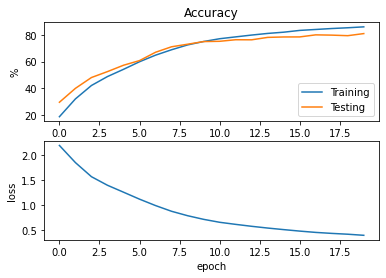

<Figure size 432x288 with 0 Axes>

In [87]:
# choose a optimizer
if optimizer.upper() == 'ADAM':
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer.upper() == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# compile the model, prepare to train
model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # from_logits=False: output layer is already softmax
    metrics=['accuracy']
)

# training
history_training = model.fit(x_train_n, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test_n, y_test))

# save model
model.save_weights(model_path)

# plot
training_accuracy = np.array(history_training.history['accuracy']) * 100
training_loss = history_training.history['loss']
testing_accuracy = np.array(history_training.history['val_accuracy']) * 100

plt.figure('Accuracy and Loss')
plt.subplot(2, 1, 1)
plt.title('Accuracy')
plt.plot(training_accuracy, label='Training')
plt.plot(testing_accuracy, label = 'Testing')
plt.ylabel('%')
plt.legend(loc='lower right')
plt.subplot(2, 1, 2)
plt.plot(training_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
t = time.localtime()
plt.savefig('history_' + time.strftime("%Y%m%d_%H%M%S", t) + '.png')